# Learning outcomes
- IOU

In [1]:
import sys
assert sys.version_info >= (3, 7)

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from util_func import *

if not cv.useOptimized():
    cv.setUseOptimized(True)
    
cv.useOptimized()

True

## IOU
IOU = |A intercept B| / |A union B|

In [2]:
def computeIOU(boxA,boxB):
    """boxA and boxB are xyxy formats"""
    
    x_start = max(boxA[0],boxB[0])
    y_start = max(boxA[1],boxB[1])
    x_end = min(boxA[2],boxB[2])
    y_end = min(boxA[3],boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0,y_end - y_start + 1)
    
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [3]:
img = cv.imread("images/lena.jfif")

In [4]:
boxes = cv.selectROIs("bounding box", img, showCrosshair = False)

cv.waitKey(0)
cv.destroyAllWindows()

In [5]:
boxes

()

In [6]:
def convert_xywh_to_xyxy(box):
    return [box[0],box[1],box[0] + box[2], box[1], box[3]]

In [7]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy,(gt[0],gt[1]),(gt[2],gt[3]),(0,0,255),2)
cv.rectangle(img_copy,(pred[0],pred[1]),(pred[2],pred[3]),(255,0,0),2)
cv.putText(img_copy,f"IOU:{computeIOU(gt,pred):.3f}",(10,25),
            cv.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)

show_img("IOU",img_copy)

IndexError: tuple index out of range

# Edge detection
Sobel x operator kernel formulation:

[-1,0,1 
-2,0,2
-1,0,1]

In [8]:
img = cv.imread("images/wood_planck.jfif",0)

th = cv.threshold(img,200,255,cv.THRESH_BINARY_INV)[1]

show_img("binary",th)

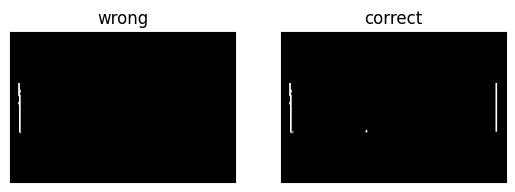

In [9]:
# sobel operators (WRONG)
sobelx_8u = cv.Sobel(th,cv.CV_8U, 1, 0)

# (CORRECT)
sobelx_32f = cv.Sobel(th,cv.CV_32F,1,0)
sobelx = cv.convertScaleAbs(sobelx_32f) # absolute and convert to uint8

plt.subplot(121), plt_img(sobelx_8u,"wrong")
plt.subplot(122), plt_img(sobelx,"correct")
plt.show()

### combine x and y edges

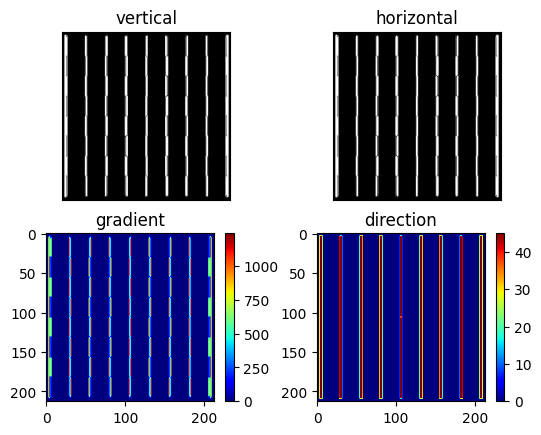

In [10]:
img = cv.imread("images/chessboard.png",0)

# sobel x and y
sobelx_32f = cv.Sobel(img,cv.CV_32F,1,0)
sobelx = cv.convertScaleAbs(sobelx_32f)
sobely_32f = cv.Sobel(img,cv.CV_32F,1,0)
sobely = cv.convertScaleAbs(sobely_32f)

# gradient and direction
gradient = cv.magnitude(sobelx_32f,sobely_32f)
direction = cv.phase(sobelx_32f,sobely_32f,angleInDegrees=True) % 180

plt.subplot(221), plt_img(sobelx,"vertical")
plt.subplot(222), plt_img(sobely,"horizontal")
plt.subplot(223), plt.imshow(gradient,cmap = "jet"), plt.title("gradient")
plt.colorbar()
plt.subplot(224), plt.imshow(direction,cmap = "jet"), plt.title("direction")
plt.colorbar()
plt.show()

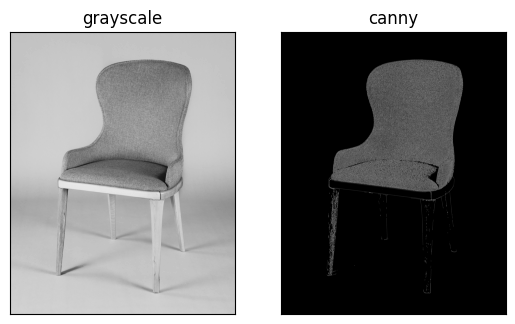

In [11]:
img = cv.imread("images/chair.jpg",0)

edge = cv.Canny(img,100,300)

plt.subplot(121), plt_img(img,"grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

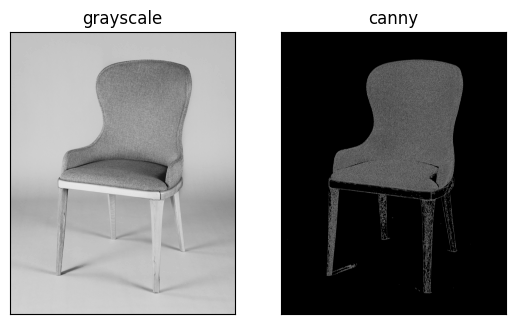

In [12]:
img = cv.imread("images/chair.jpg",0)

edge = cv.Canny(img,30,150)

plt.subplot(121), plt_img(img,"grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

# Exercise

In [13]:
img = cv.imread("images/chair.jfif")
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

ratio = 2.5
trackbar_name = "Th1"
wn = "canny"
ksize = 3

def cannyThreshold(val):
    """Trackbar callback function"""
    edge = cv.Canny(gray,val,ratio*val,apertureSize = ksize)
    mask = edge != 0
    res = img * (mask[:,:,None].astype(np.uint8))
    cv.imshow(wn,res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbar_name, wn,10,100,cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
def auto_canny(img,method,sigma = 0.33):
    """Args:
    img:grayscale image
    method: median, otsu, triangle
    sigma: 0.33 (default)"""
    
    if method == "median":
        Th = np.median(img)
        
    elif method == "otsu":
        Th = cv.threshold(img,0,255,cv.THRESH_OTSU)[0]
        
    elif method == "triangle":
        Th = cv.threshold(img,0,255,cv.THRESH_TRIANGLE)[0]

    else:
        raise Exception("Method specified unavailable")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img,lowTh,highTh)

## Contour detection

In [14]:
rect = np.zeros((256,256),dtype = np.uint8)

cv.rectangle(rect,(25,25),(231,231),255,-1)

show_img("rect",rect)

In [15]:
contours, _ = cv.findContours(rect,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

len(contours)

1

In [16]:
contours

(array([[[ 25,  25]],
 
        [[ 25, 231]],
 
        [[231, 231]],
 
        [[231,  25]]], dtype=int32),)

In [17]:
img_bgr = cv.imread("images/monitor.jfif")
img = cv.imread("images/monitor.jfif",0)

#threshold
th = cv.threshold(img,200,255,cv.THRESH_BINARY_INV)[1]

show_img("threshold",th)

contours, _ = cv.findContours(th,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

In [18]:
len(contours)

12

In [19]:
cv.drawContours(img_bgr,contours,-1,(0,255,0),1)


show_img("contours",img_bgr)

In [20]:
contours, _ = cv.findContours(th,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr,contours,-1,(0,255,0),1)

show_img("contours",img_bgr_copy)

In [21]:
contours, _ = cv.findContours(th,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

In [22]:
# contours with maximum number of points
length = [len(c) for c in contours]
contour_largest = contours[np.argmax(length)]

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy,[contour_largest],-1,(0,255,0),1)

show_img("contours",img_bgr_copy)

In [23]:
cnt = contour_largest

## Contour features

In [24]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [25]:
# centroid (center of mass)
cx = int(M["m10"]/M["m00"])
cy = int(M["m01"]/M["m00"])

print(f"the centroid of monitor: {(cx,cy)}")


the centroid of monitor: (105, 103)


In [26]:
# area and perimeter
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt,True)

print(f"The area of monitor:{area}")
print(f"The perimeter of monitor:{peri:.3f}")

The area of monitor:37113.5
The perimeter of monitor:1056.777


In [27]:
img = cv.imread("images/remote-controller.webp")

In [28]:
# resize -> grayscale -> bilateral filter -> edge detection -> find contour 
# contour features
factor = 300 / img.shape[1]
img = cv.resize(img,None,fx = factor,fy=factor)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray,7,19,13)
edge = auto_canny(blur,method="triangle")

# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# area
contours = sorted(contours,key=cv.contourArea,reverse=True)[:5]
screen = None
img_copy = img.copy()

for c in contours:
    peri = cv.arcLength(c,True)
    approx = cv.approxPolyDP(c,0.1*peri,True)
    
    if len(approx) == 4:
        screen = c
        break
        
cv.drawContours(img_copy,[screen],-1,(0,255,0),2)
show_img("screen", img_copy)

NameError: name 'auto_canny' is not defined

# Circularity
 Circularity = (4*pi*Area)/Perimeter^2

## Demo on red object detector

In [60]:
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam detected")

# factor
fixed_width = min_area = 500
factor = fixed_width / cap.get(3) # frame width
kernel = np.ones((3, 3), dtype = np.uint8)

while (1):
    ret, frame = cap.read()
    
    if not ret:
        print("No frame is received")
        break
        
        # resize, blur, change to hsv, inRange, mask integration, morphological operation
        # find contour, bounding box
        resize = cv.resize(frame, None, fx=factor, fy=factor)
        blur = cv.GaussianBlur(resized, (5, 5), 0)
        img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
        
        mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
        mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
        mask = cv.add(mask1, mask2)
        
        # suppress noise
        mask = cv.morphologyEx(mask, MORPH_OPEN, kernel, iterations=2)
        
        # find contours
        countours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        
        bbs=[]
        for c in contours:
            area = cv.contourArea(c)
            if area > min_area:
                bb = cv.boundingRect(c)
                M = cv.moments(c)
                cx, cy = int(M["m10"]/M["m00"], int(M["m01"]/M["m00"]))
                centroids.append((cx, cy))
                bbs.append(bb)
                
        for bb, centroid in zip(bbs, centroids):
            x, y, w, h = bb
            cv.rectangle(resized, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv.circle(resized, centroid, 2, (255, 0, 0), -1)
            
        cv.imshow("red object", resized)
        k = cv.waitKey(1) & 0xFF
        if k == 27:
            break

cap.release()

No frame is received


## Exercise 
1. Experiment with different edge detectors: Sobel, Laplacian, Prewitt, Scharr derivatives and Canny operators (all with aperture size of 3) on image named 'pineapple.jfif'. Comment on the results.

In [46]:
# Load the image
img = cv.imread("images/pineapple.jfif", 0)

# Apply different edge detection methods
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = np.sqrt(sobel_x**2 + sobel_y**2)

laplacian = cv2.Laplacian(img, cv2.CV_64F)

prewitt_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
prewitt_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
prewitt_edges = np.sqrt(prewitt_x**2 + prewitt_y**2)

scharr_x = cv2.Scharr(img, cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(img, cv2.CV_64F, 0, 1)
scharr_edges = np.sqrt(scharr_x**2 + scharr_y**2)

canny_edges = cv2.Canny(img, 100, 200)

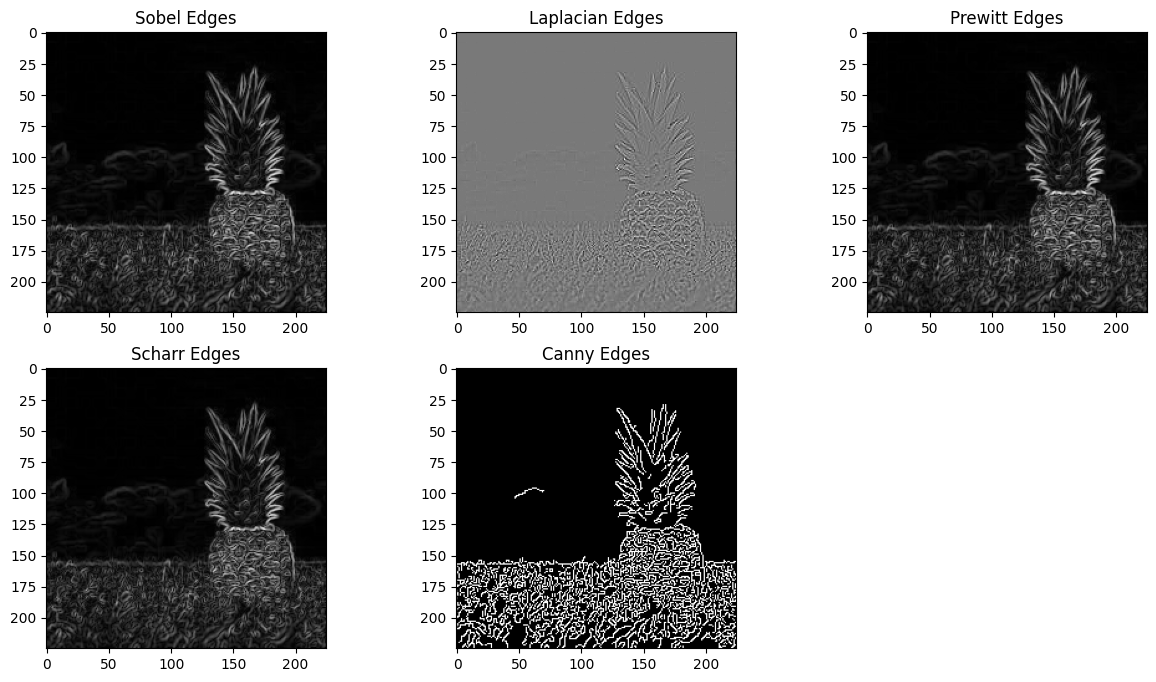

In [54]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(sobel_edges, cmap='gray')
plt.title('Sobel Edges')

plt.subplot(2, 3, 2)
plt.imshow(laplacian, cmap='gray')
plt.title('Laplacian Edges')

plt.subplot(2, 3, 3)
plt.imshow(prewitt_edges, cmap='gray')
plt.title('Prewitt Edges')

plt.subplot(2, 3, 4)
plt.imshow(scharr_edges, cmap='gray')
plt.title('Scharr Edges')

plt.subplot(2, 3, 5)
plt.imshow(canny_edges, cmap='gray')
plt.title('Canny Edges')

plt.show()

2. Write a program to identify the white object (probably laptop) present in the image 'electronic.jfif'. Draw bounding boxes on the objects.

In [56]:
whiteLow = (0, 0, 200)
whiteHigh = (255, 50, 255)

img = cv.imread("images/electronic.jfif")

if img is None:
    print("Image not loaded. Please check the image path.")
else:
    factor = 500 / img.shape[1]
    resized = cv.resize(img, None, fx=factor, fy=factor)
    blur = cv.GaussianBlur(resized, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)

    mask = cv.inRange(img_hsv, whiteLow, whiteHigh)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, np.ones((3, 3), dtype=np.uint8), iterations=2)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    for c in contours:
        area = cv.contourArea(c)
        if area > 100:
            bb = cv.boundingRect(c)
            x, y, w, h = bb
            cv.rectangle(resized, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv.imshow("White Object Detection", resized)
    cv.waitKey(0)
    cv.destroyAllWindows()


3. Isolate the clock with the aid of edge detection and contours' properties. The example result should be as follows: segmented_clock

In [64]:
whiteLow = (0, 0, 200)
whiteHigh = (255, 50, 255)

img = cv.imread("images/clock.jpg")

if img is None:
    print("Image not loaded. Please check the image path.")
else:
    factor = 500 / img.shape[1]
    resized = cv.resize(img, None, fx=factor, fy=factor)
    blur = cv.GaussianBlur(resized, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv2.COLOR_BGR2HSV)

    mask = cv.inRange(img_hsv, whiteLow, whiteHigh)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, np.ones((3, 3), dtype=np.uint8), iterations=2)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    for c in contours:
        area = cv.contourArea(c)
        if area > 100:
            (x, y), radius = cv.minEnclosingCircle(c)
            center = (int(x), int(y))
            radius = int(radius)
            cv.circle(resized, center, radius, (0, 255, 0), 2)

    cv.imshow("White Object Detection", resized)
    cv.waitKey(0)
    cv.destroyAllWindows()